In [1]:
import os
import cv2
import PIL
import pickle
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from matplotlib.gridspec import GridSpec
from sklearn.model_selection import ParameterGrid

In [2]:
np.random.seed(1234)
tf.random.set_seed(1234)

### 데이터 가져오기

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
flower_list = [s for s in os.listdir(data_dir) if 'txt' not in s]

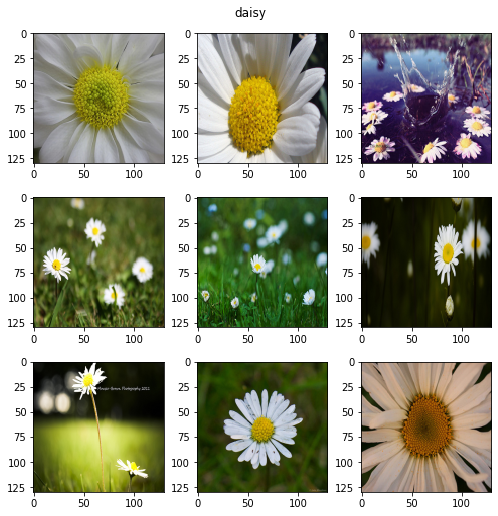

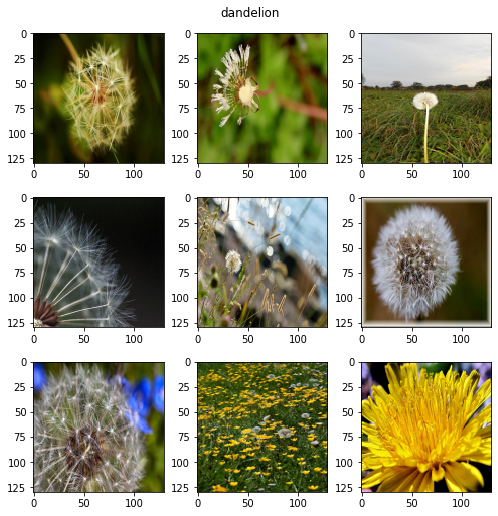

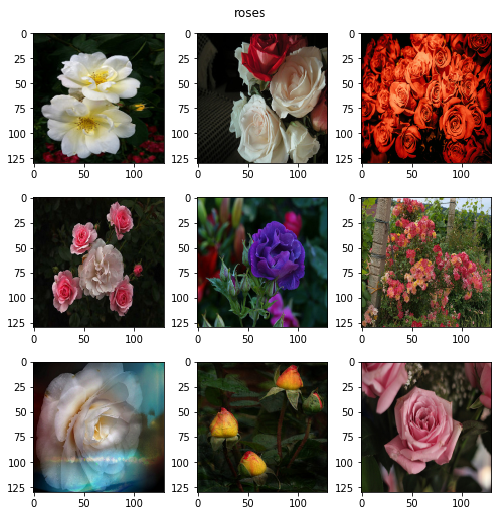

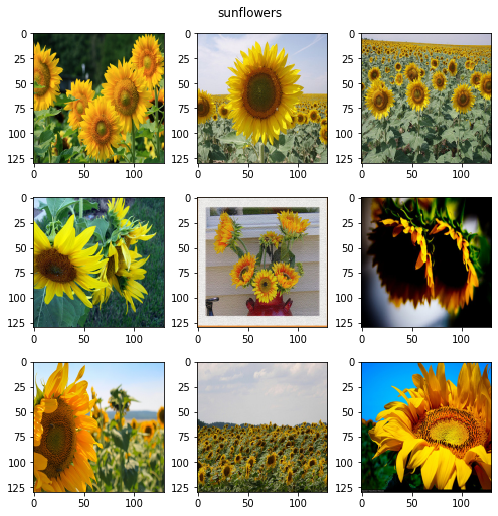

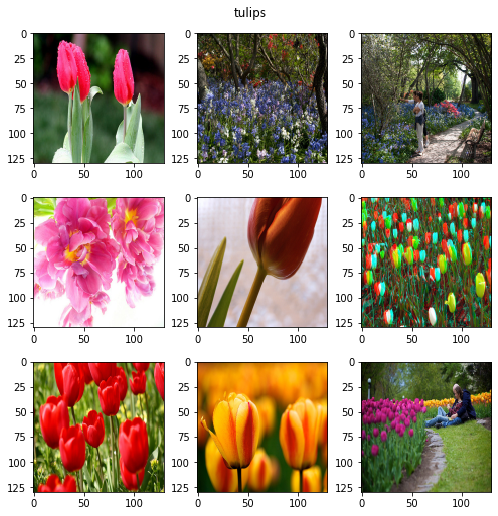

In [5]:
train_x_dat = []; valid_x_dat = []; test_x_dat = []
train_y_dat = []; valid_y_dat = []; test_y_dat = []

for flower_name in flower_list :
#     flower_name = flower_list[0]
    flower_dir = os.path.join(data_dir,flower_name)
    flower_png_list = os.listdir(flower_dir)
    
    # Train
    # cv2는 BRG이기 떄문에 cv2.cvtColor함수로 BRG -> RGB로 변경
    train_x_data_list = np.array([cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(flower_dir,s)),cv2.COLOR_BGR2RGB), (130, 130), interpolation = cv2.INTER_AREA) for s in flower_png_list[0:400]])
    train_y_data_list = np.array([flower_name for s in range(train_x_data_list.shape[0])])
    train_x_dat.append(train_x_data_list)
    train_y_dat.append(train_y_data_list)
    
    
    # Valid
    # cv2는 BRG이기 떄문에 cv2.cvtColor함수로 BRG -> RGB로 변경
    valid_x_data_list = np.array([cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(flower_dir,s)),cv2.COLOR_BGR2RGB), (130, 130), interpolation = cv2.INTER_AREA) for s in flower_png_list[400:500]])
    valid_y_data_list = np.array([flower_name for s in range(valid_x_data_list.shape[0])])
    valid_x_dat.append(valid_x_data_list)
    valid_y_dat.append(valid_y_data_list)
    
    # Test
     # cv2는 BRG이기 떄문에 cv2.cvtColor함수로 BRG -> RGB로 변경
    test_x_data_list = np.array([cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(flower_dir,s)),cv2.COLOR_BGR2RGB), (130, 130), interpolation = cv2.INTER_AREA) for s in flower_png_list[500:600]])
    test_y_data_list = np.array([flower_name for s in range(test_x_data_list.shape[0])])
    test_x_dat.append(test_x_data_list)
    test_y_dat.append(test_y_data_list)
    
    
    # graph
    fig, ax = plt.subplots(3,3, figsize = (7,7))
#     ax = ax.ravel()
    for i in range(3):
        ax[0][i].imshow(train_x_data_list[i])
    for i in range(3):
        ax[1][i].imshow(valid_x_data_list[i])
    for i in range(3):
        ax[2][i].imshow(test_x_data_list[i])
        
    fig.tight_layout()    
    fig.suptitle(flower_name, y = 1.02) 

### 데이터 전처리

In [6]:
train_y_dat = np.array(train_y_dat).flatten()
valid_y_dat = np.array(valid_y_dat).flatten()
test_y_dat = np.array(test_y_dat).flatten()

In [7]:
train_onehot_y = np.array(pd.get_dummies(train_y_dat))
valid_onehot_y = np.array(pd.get_dummies(valid_y_dat))
test_onehot_y = np.array(pd.get_dummies(test_y_dat))

train_array_x = np.array(train_x_dat).reshape(len(train_y_dat),130,130,3)
valid_array_x = np.array(valid_x_dat).reshape(len(valid_y_dat),130,130,3)
test_array_x = np.array(test_x_dat).reshape(len(test_y_dat),130,130,3)

In [8]:
# Scale
train_array_x = train_array_x/255
valid_array_x = valid_array_x/255
test_array_x = test_array_x/255

### CNN Model

In [9]:
class CnnModel():
    def __init__(self, sInit) :
        self.sInit = sInit
        
        if self.sInit == 'random_uniform' :
            self.initializer = tf.keras.initializers.random_uniform(seed=1234)
        if self.sInit == 'glorot_uniform' :
            self.initializer = tf.keras.initializers.glorot_uniform(seed=1234)
        if self.sInit == 'he_uniform' :
            self.initializer = tf.keras.initializers.he_uniform(seed=1234)
        if self.sInit == 'random_normal' :
            self.initializer = tf.keras.initializers.random_normal(seed=1234)
        if self.sInit == 'glorot_normal' :
            self.initializer = tf.keras.initializers.glorot_normal(seed=1234)
        if self.sInit == 'he_normal' :
            self.initializer = tf.keras.initializers.he_normal(seed=1234)
        if self.sInit == 'orthogonal' :
            self.initializer = tf.keras.initializers.orthogonal(seed=1234)    
            
        self._build()
        self._compile()
        
    def _build(self) :
        self.input_layer = tf.keras.Input(shape = (130,130,3))
        self.conv1 = tf.keras.layers.Conv2D(4, kernel_size = 3, padding = 'same', strides = 1, name = "conv1", kernel_initializer = self.initializer)(self.input_layer)
        self.conv1 = tf.keras.layers.BatchNormalization( name = "conv1_nor")(self.conv1)
        self.conv1 = tf.keras.layers.Activation('relu', name = "conv1_act")(self.conv1)
        self.conv1 = tf.keras.layers.Dropout(0.25, name = "conv1_drop")(self.conv1)
        self.conv1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), name = "conv1_pool")(self.conv1)
        self.conv2 = tf.keras.layers.Conv2D(16, kernel_size = 3, padding = 'same', strides = 1, name = "conv2", kernel_initializer = self.initializer)(self.conv1)
        self.conv2 = tf.keras.layers.BatchNormalization( name = "conv2_nor")(self.conv2)
        self.conv2 = tf.keras.layers.Activation('relu', name = "conv2_act")(self.conv2)
        self.conv2 = tf.keras.layers.Dropout(0.25, name = "conv2_drop")(self.conv2)
        self.conv2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), name = "conv2_pool")(self.conv2)
        self.faltten = tf.keras.layers.Flatten()(self.conv2)
        self.dense = tf.keras.layers.Dropout(0.25, name = "dense_drop1")(self.faltten)
        self.dense = tf.keras.layers.Dense(512, activation = 'relu', kernel_initializer = self.initializer, name = 'dense1')(self.dense)
        self.dense = tf.keras.layers.Dropout(0.5, name = "dense_drop2")(self.dense)
        self.output_layer = tf.keras.layers.Dense(5, activation = 'softmax', kernel_initializer = self.initializer, kernel_regularizer=tf.keras.regularizers.l2(l2 = 0.01), name = 'dense2')(self.dense)
        self.cnn_model = tf.keras.Model(inputs = self.input_layer, outputs = self.output_layer)
   
    def _compile(self):
        self.cnn_model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = 'acc')
        

### 모델 초기 값 저장

In [10]:
# Initializer 별 모델 생성
grid = pd.DataFrame(ParameterGrid({"sInit" : ['random_uniform','glorot_uniform','he_uniform','random_normal','glorot_normal','he_normal','orthogonal']}))
model_list = []
model_weight_dict = {}

for idx,params in grid.iterrows():
    
    # Model 생성
    model = CnnModel(params['sInit'])
    model_list.append(model)
    
    # 초기 Weight 저장
    model.cnn_model.save_weights(f'C:/Users/begas/Model/Initial/{params["sInit"]}/model')
    
#     # 초기 Weight 저장
#     weight_dict = {}
#     for layer in model.cnn_model.layers[1:] :
#         if len(layer.get_weights()) and ('nor' not in layer.name) > 0:
#             weight_dict[layer.name] = layer.get_weights()[0]

#     model_weight_dict[params['sInit']] = weight_dict  

In [11]:
# 초기 Weight Pickle로 저장해 두기
# with open('C:/Users/begas/OUT/init_weight.pickle', 'wb') as handle:
#     pickle.dump(model_weight_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('C:/Users/begas/OUT/init_weight.pickle', 'rb') as handle:
#     model_weight_dict = pickle.load(handle)

### 모델 학습

params_idx : 0 / model init : random_uniform
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to 

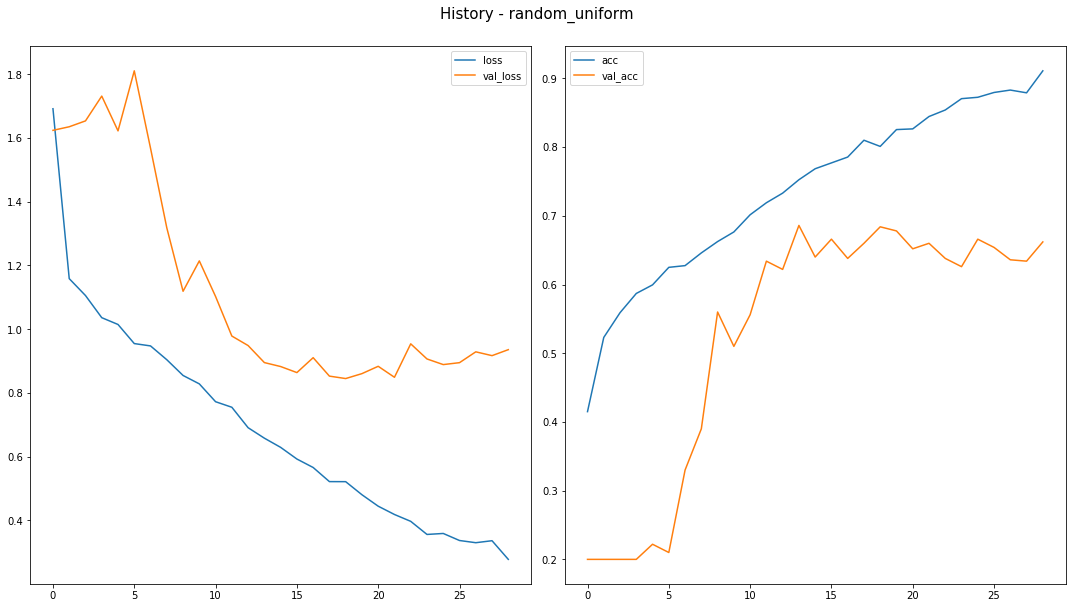

params_idx : 1 / model init : glorot_uniform
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to 

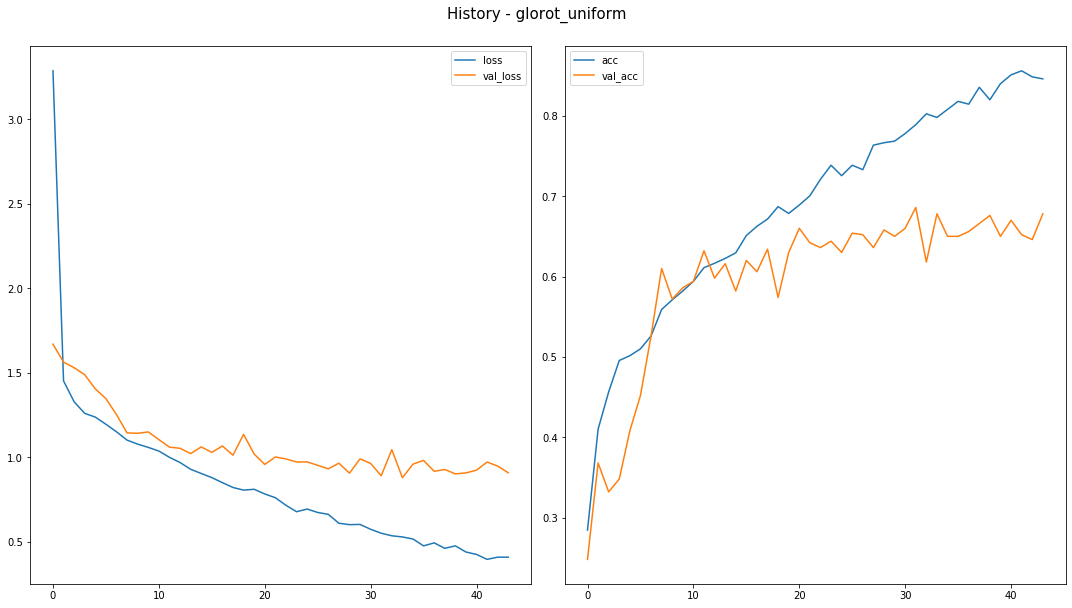

params_idx : 2 / model init : he_uniform
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the 

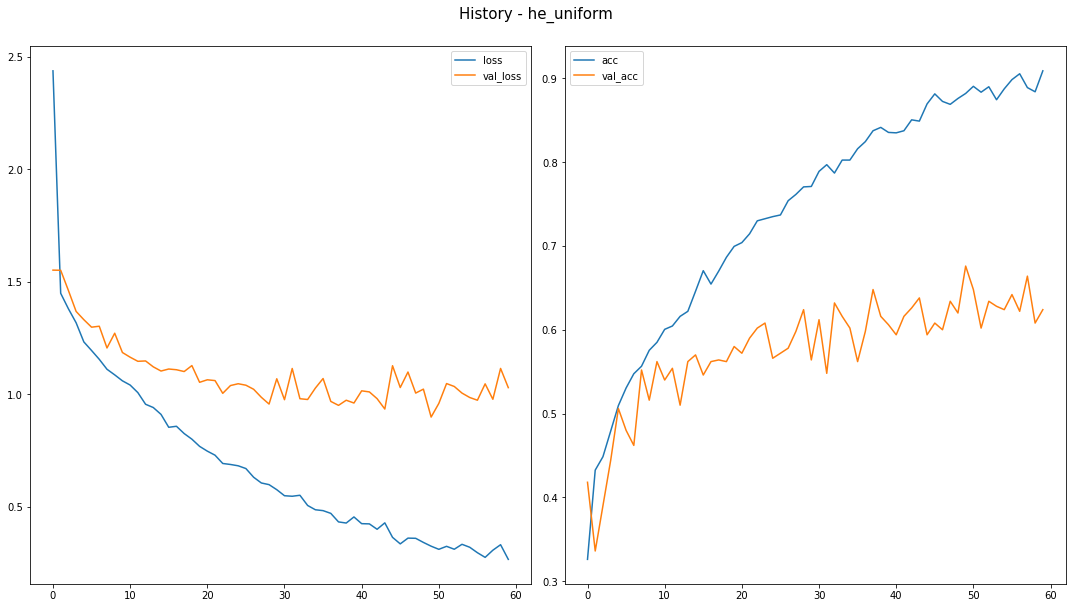

params_idx : 3 / model init : random_normal
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to t

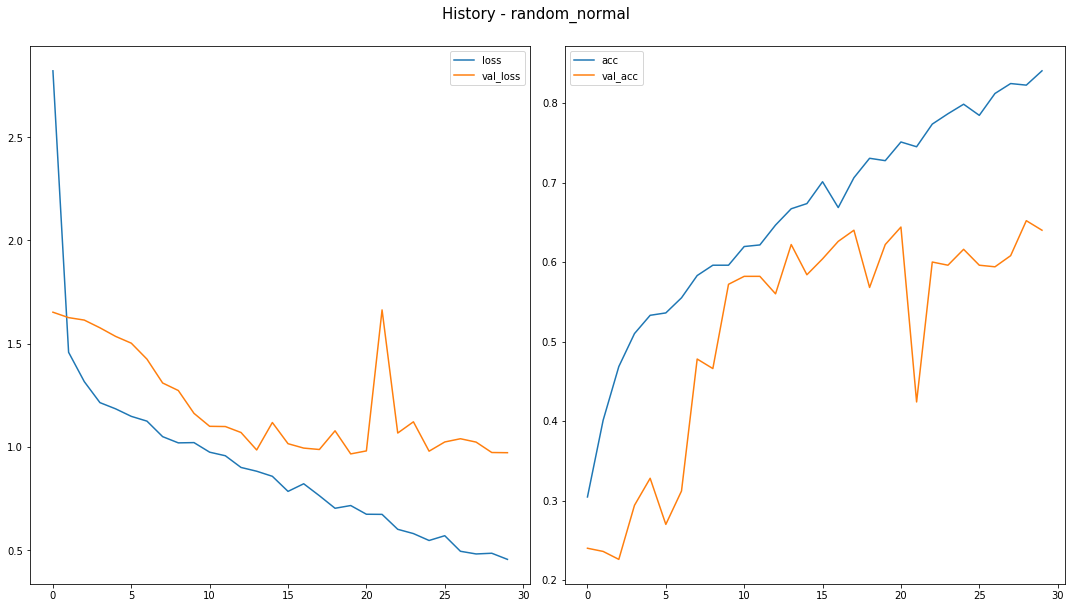

params_idx : 4 / model init : glorot_normal
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to t

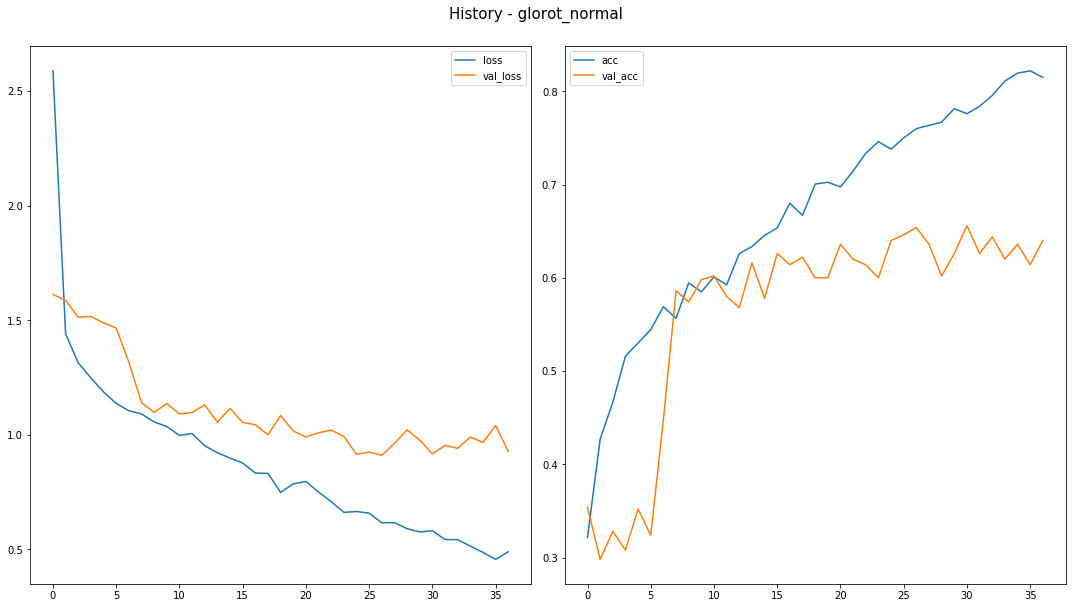

params_idx : 5 / model init : he_normal
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the T

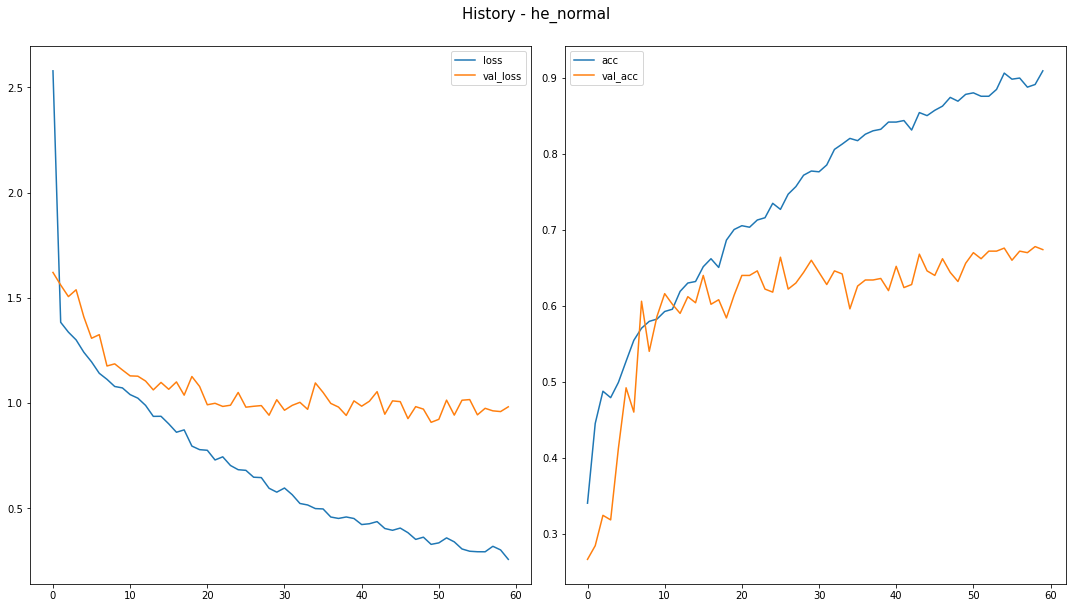

params_idx : 6 / model init : orthogonal
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the 

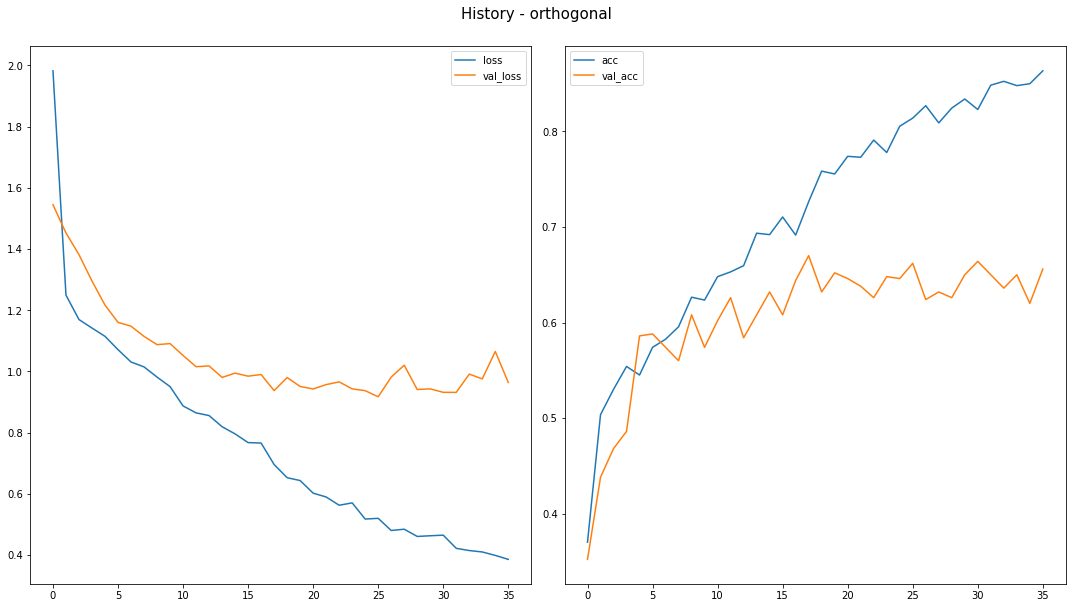

In [12]:
for idx,params in grid.iterrows():
    print(f'params_idx : {idx} / model init : {params["sInit"]}')
    
    # Fit Model
    EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, verbose=0, mode='min', restore_best_weights=True)
    history = model_list[idx].cnn_model.fit(train_array_x,train_onehot_y, validation_data=(valid_array_x, valid_onehot_y), epochs = 100, verbose=0, callbacks=[EarlyStopping])
    
    # Save Model Weights
    model_list[idx].cnn_model.save_weights(f'C:/Users/begas/Model/Final/{params["sInit"]}/model')
    
    # Model History Plot
    fig, ax = plt.subplots(1,2,figsize = (15,8))
    ax[0].plot(history.epoch, history.history['loss'], label = 'loss')
    ax[0].plot(history.epoch, history.history['val_loss'], label = 'val_loss')
    ax[0].legend()    

    ax[1].plot(history.epoch, history.history['acc'], label = 'acc')
    ax[1].plot(history.epoch, history.history['val_acc'], label = 'val_acc')
    ax[1].legend()   

    fig.suptitle(f'History - {params["sInit"]}', fontsize = 15, y = 1.05)
    fig.tight_layout()
    plt.show()    

### 초기 / 최종 Weight, FeatureMap 비교

params_idx : 0 / model init : random_uniform
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to 

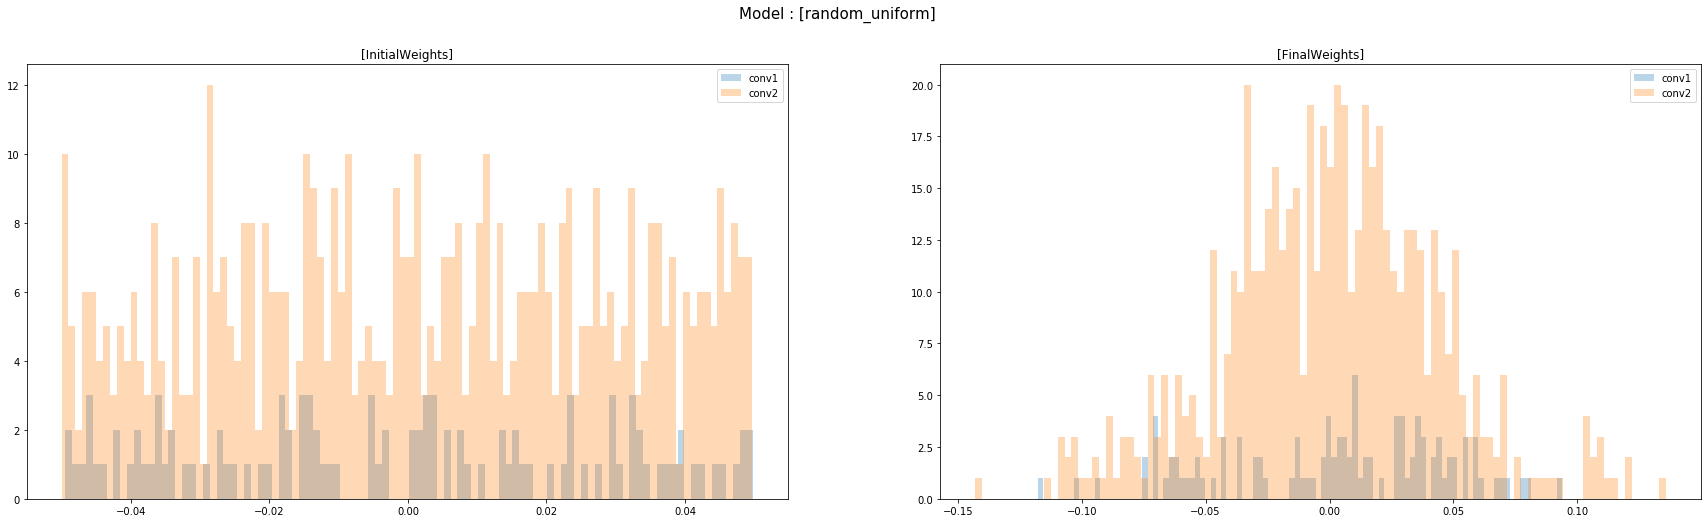

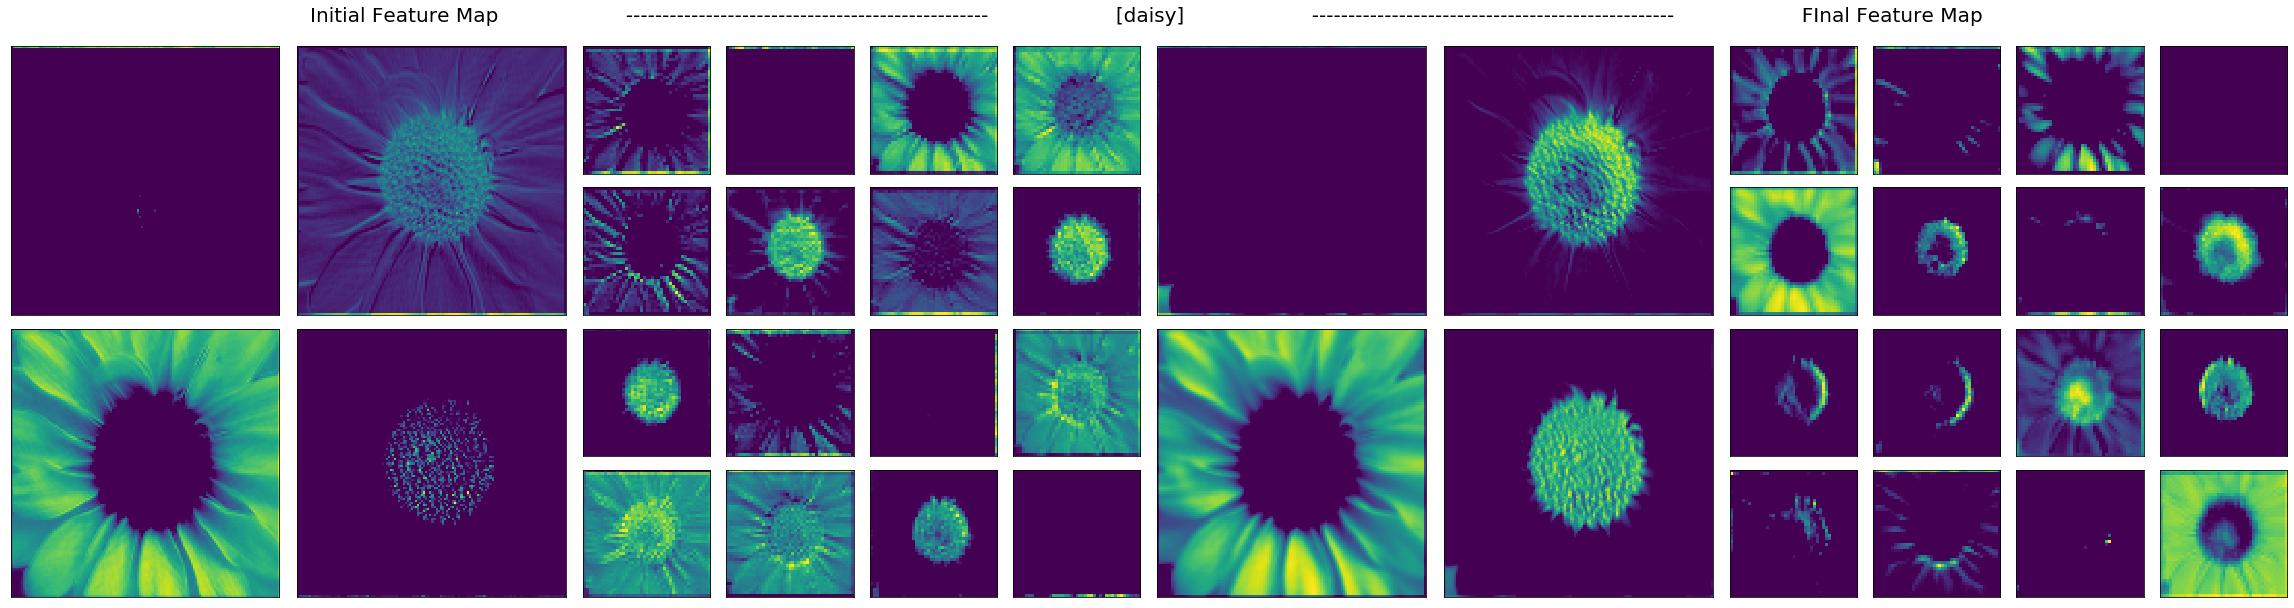

params_idx : 1 / model init : glorot_uniform
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to 

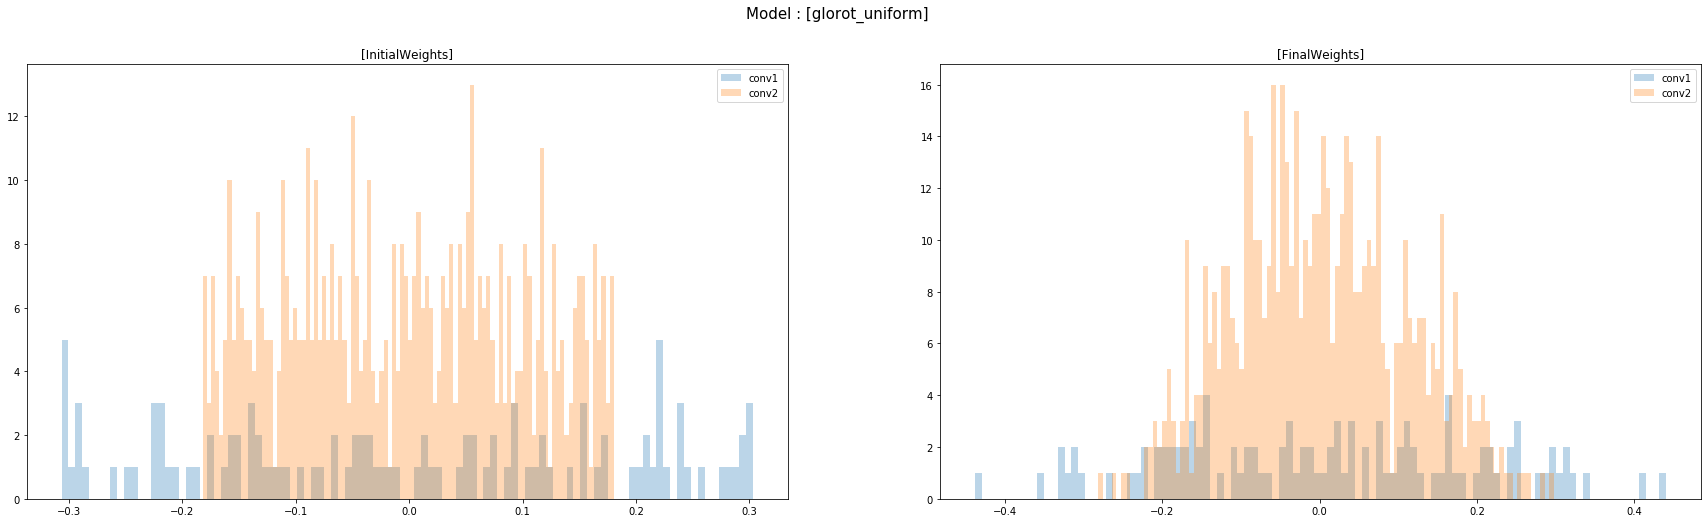

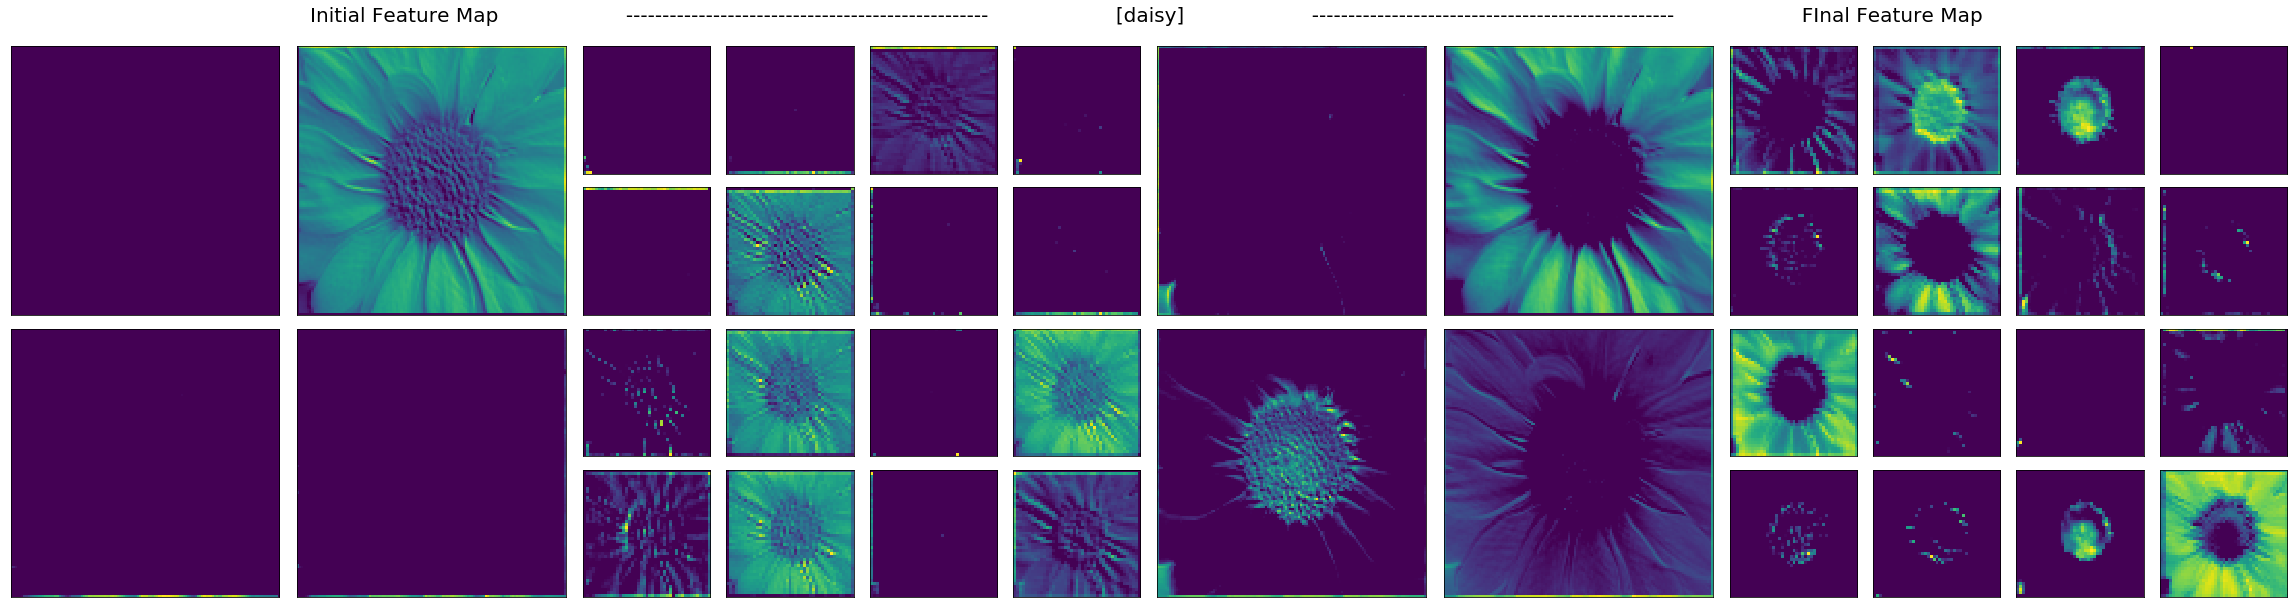

params_idx : 2 / model init : he_uniform
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the 

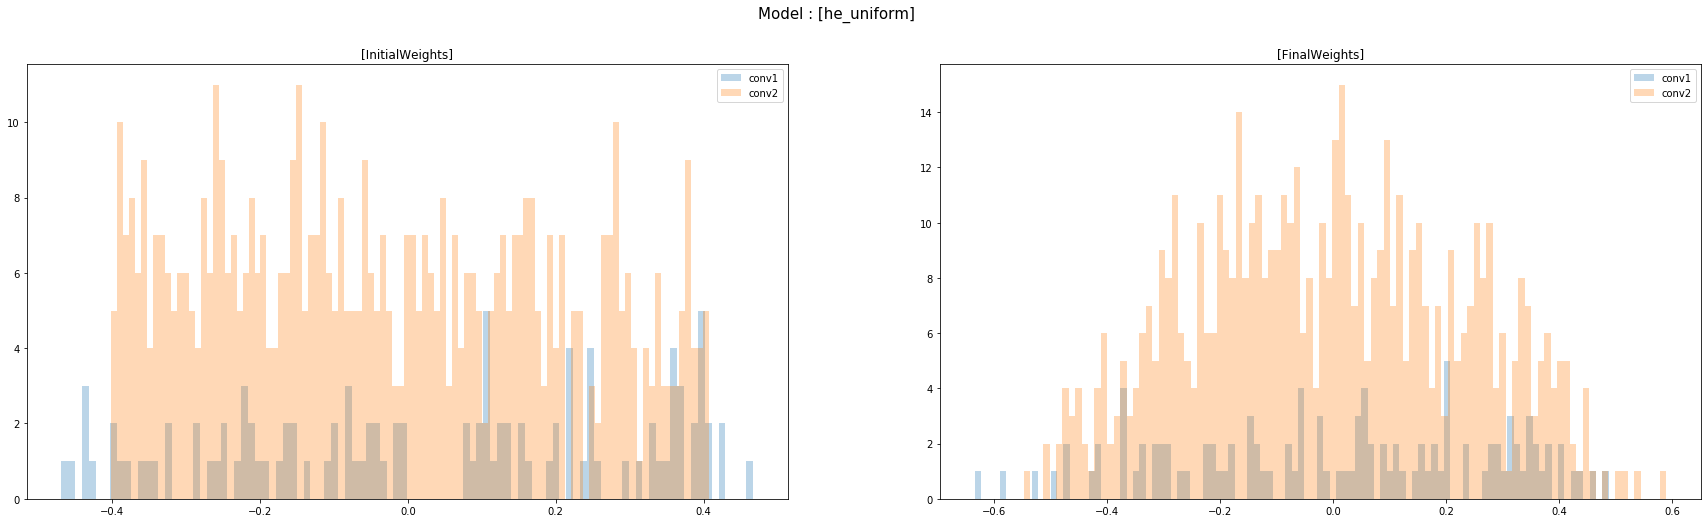

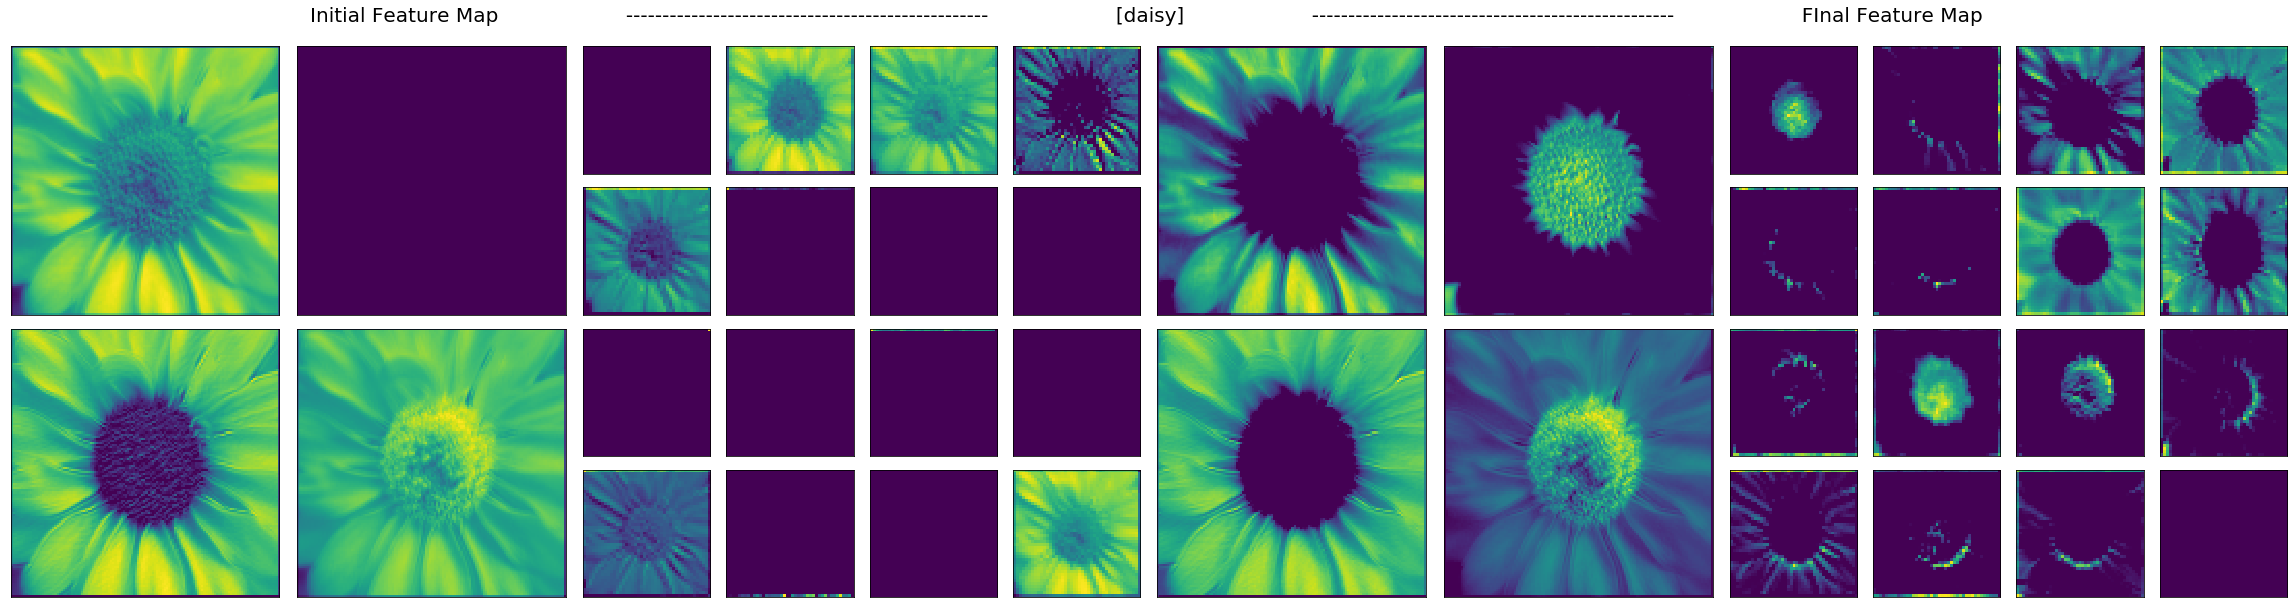

params_idx : 3 / model init : random_normal
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to t

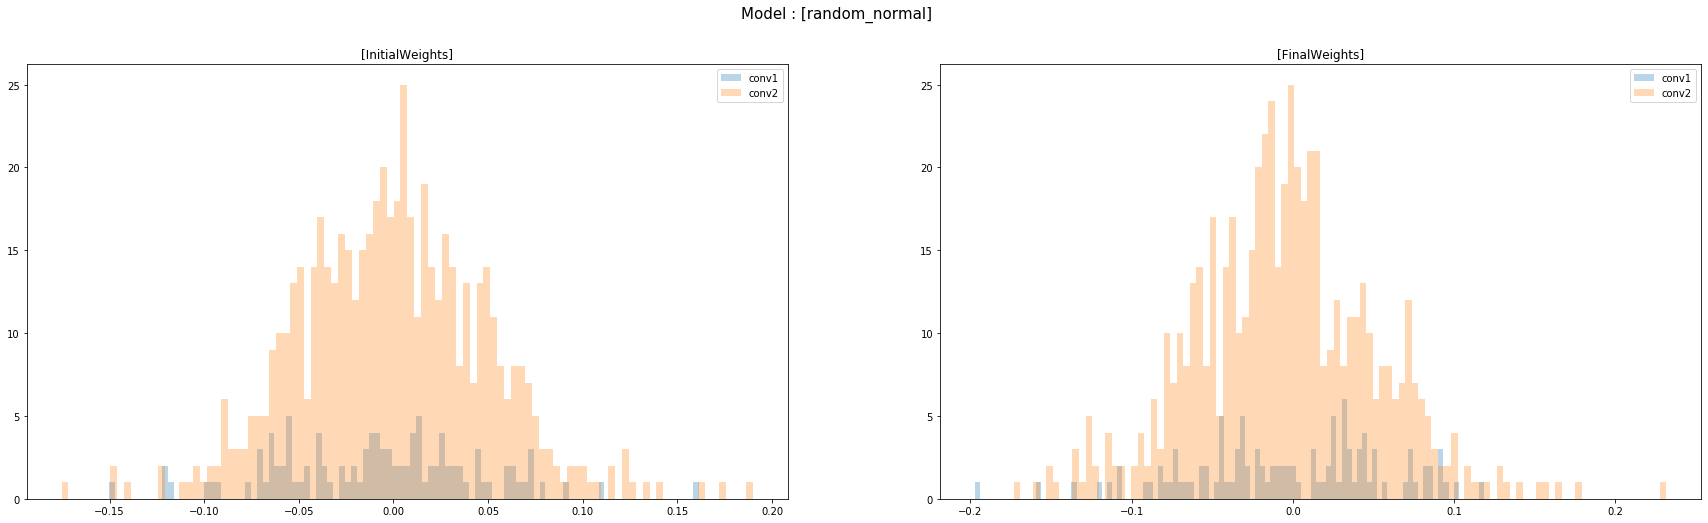

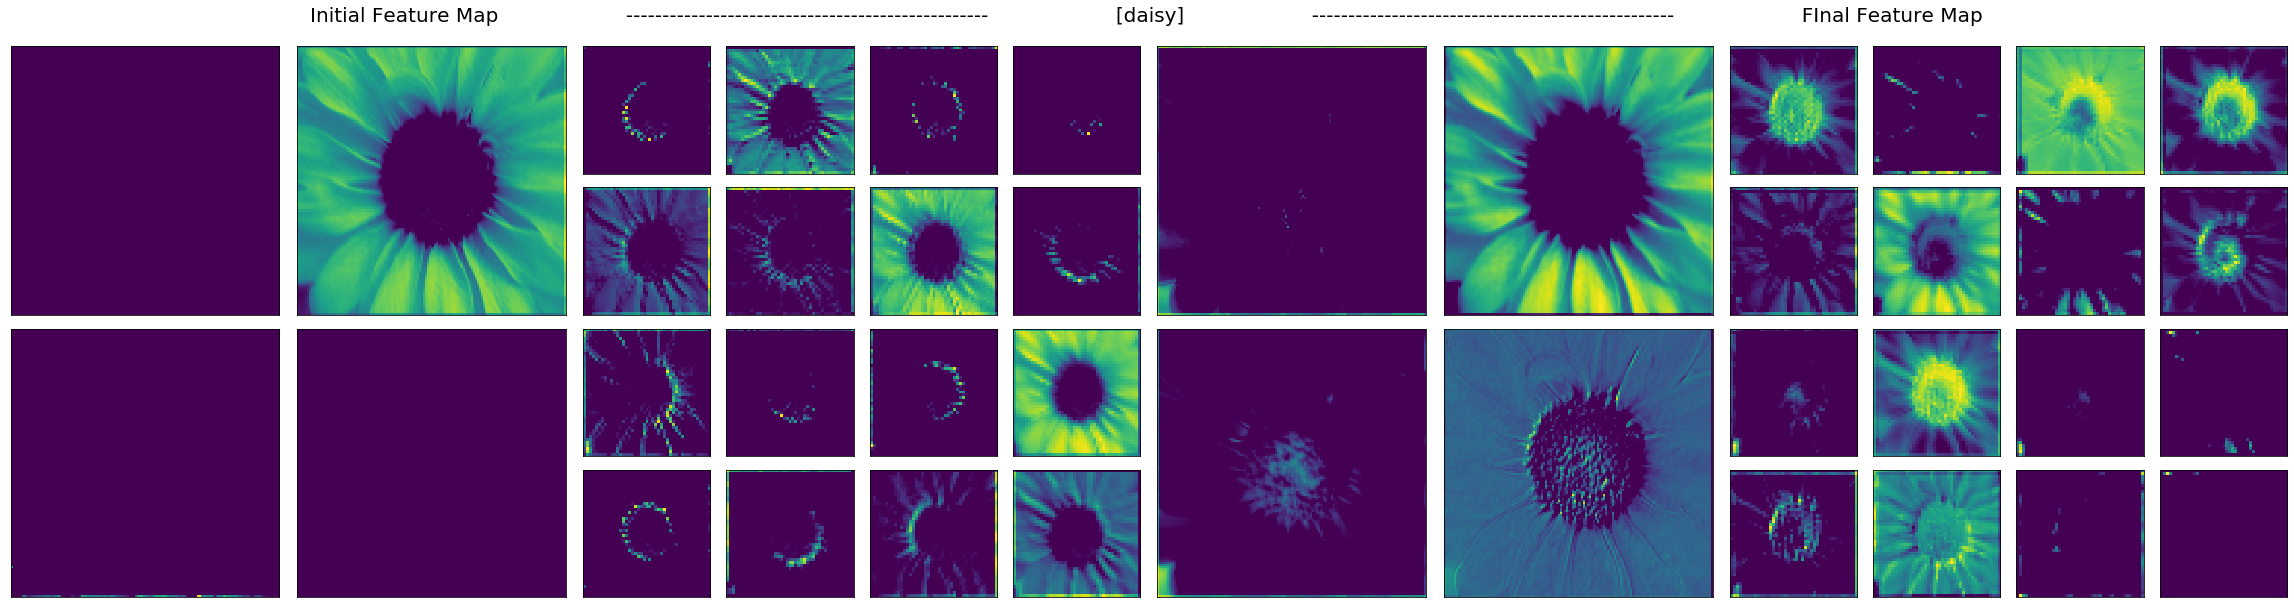

params_idx : 4 / model init : glorot_normal
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to t

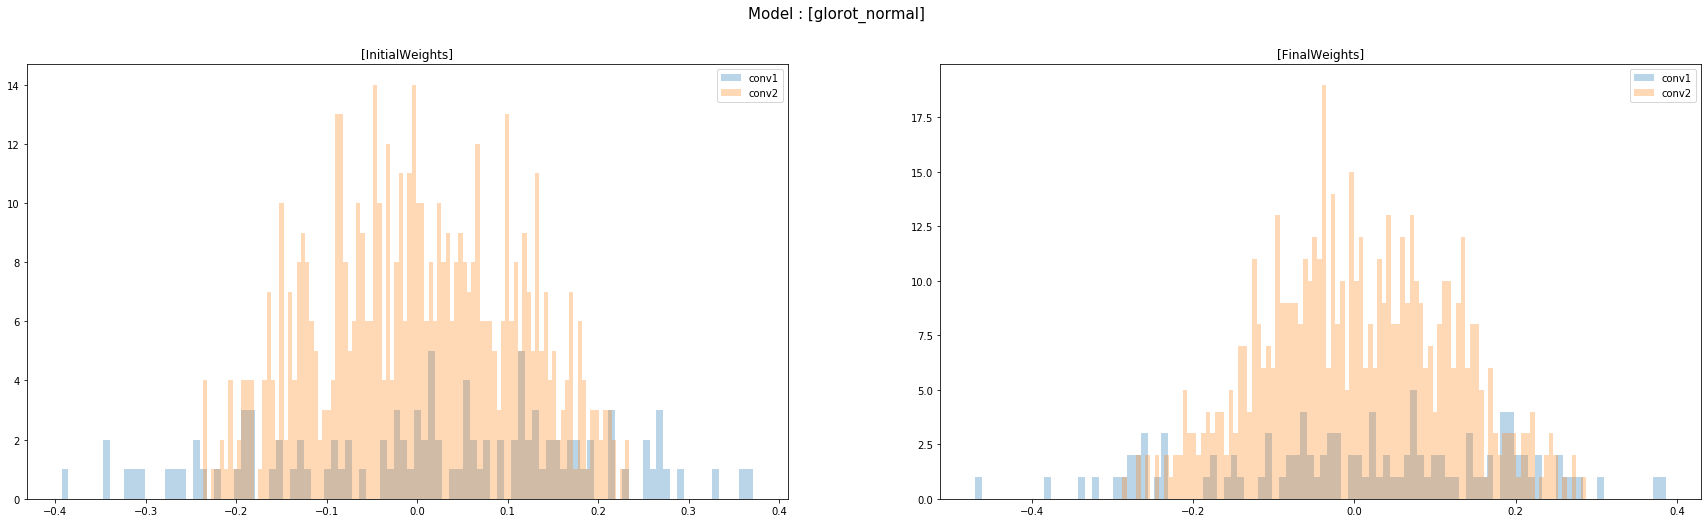

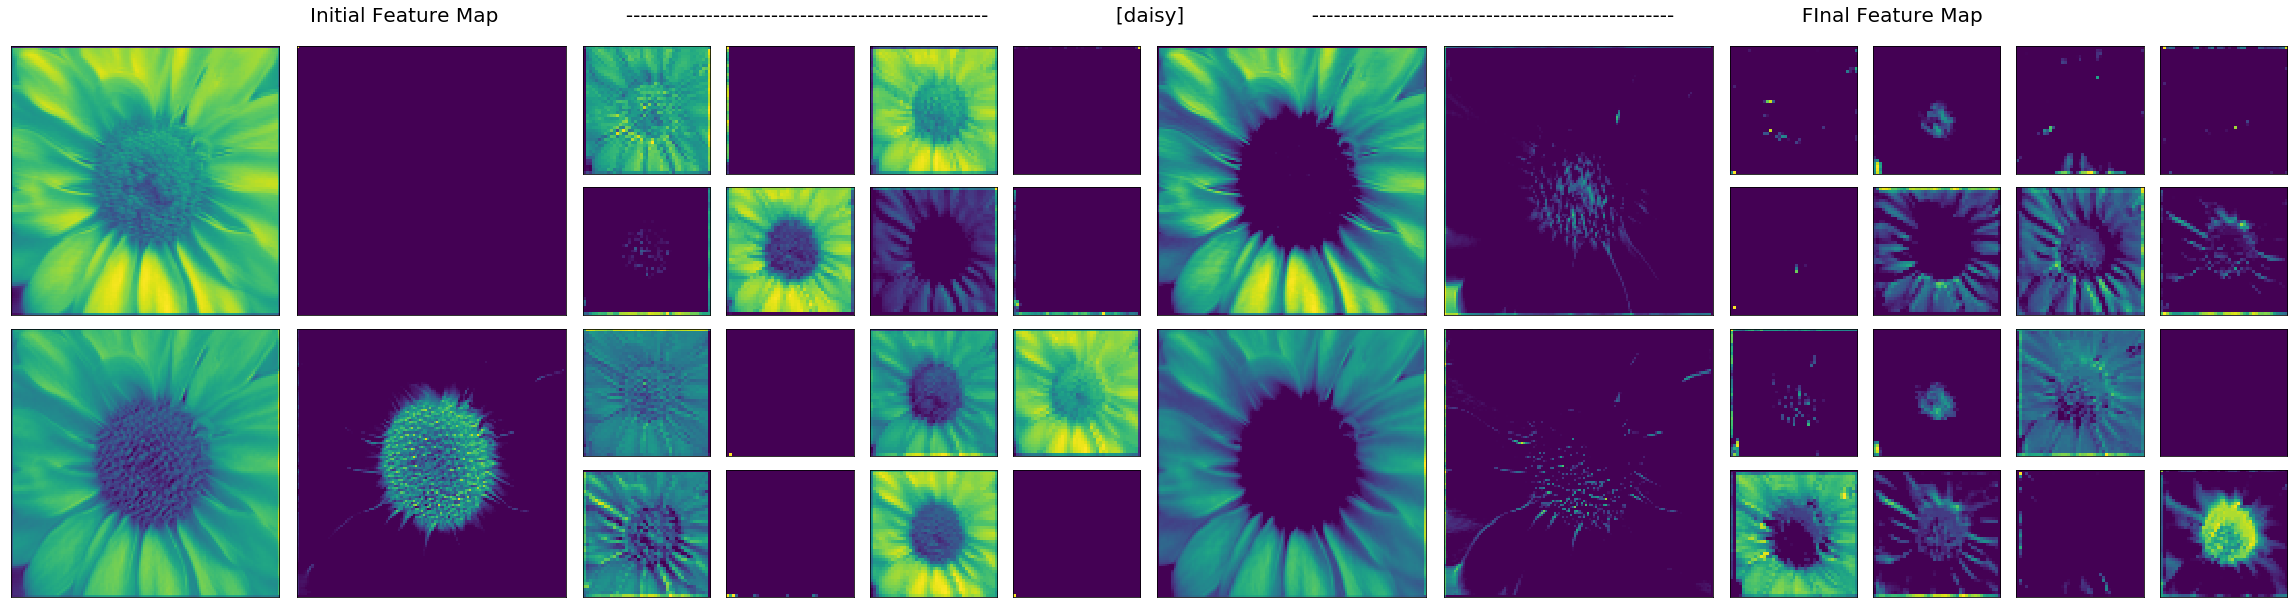

params_idx : 5 / model init : he_normal
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the T

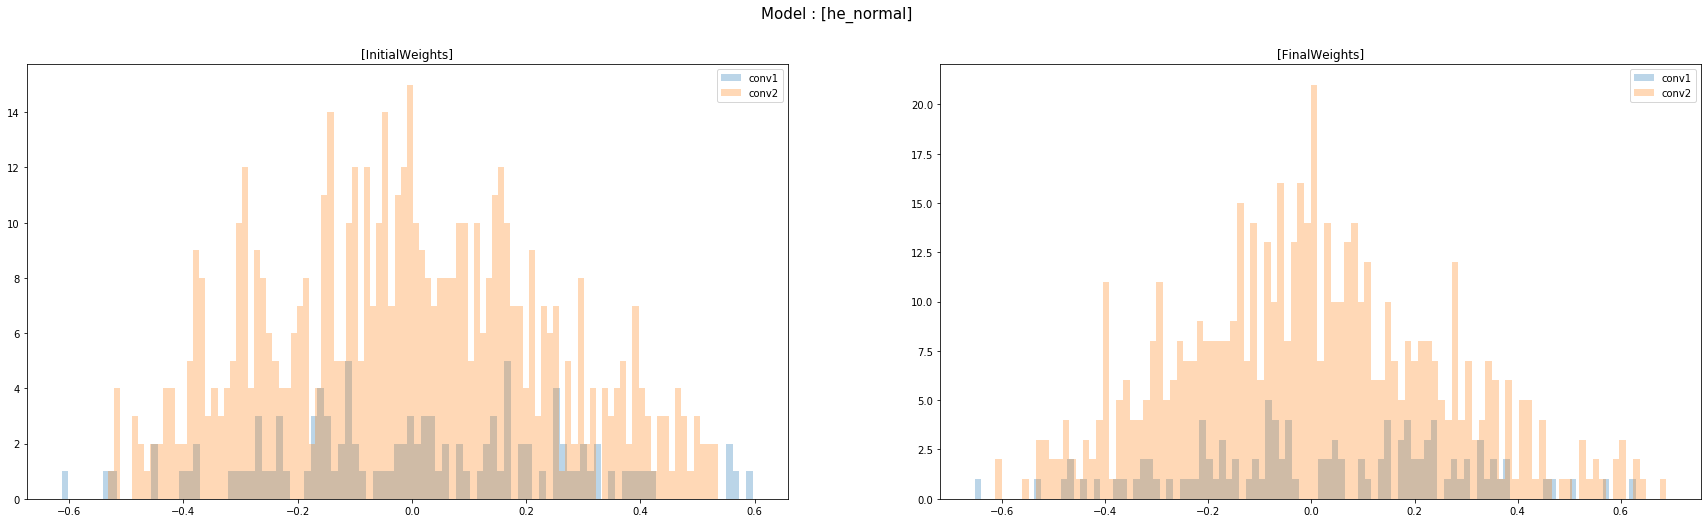

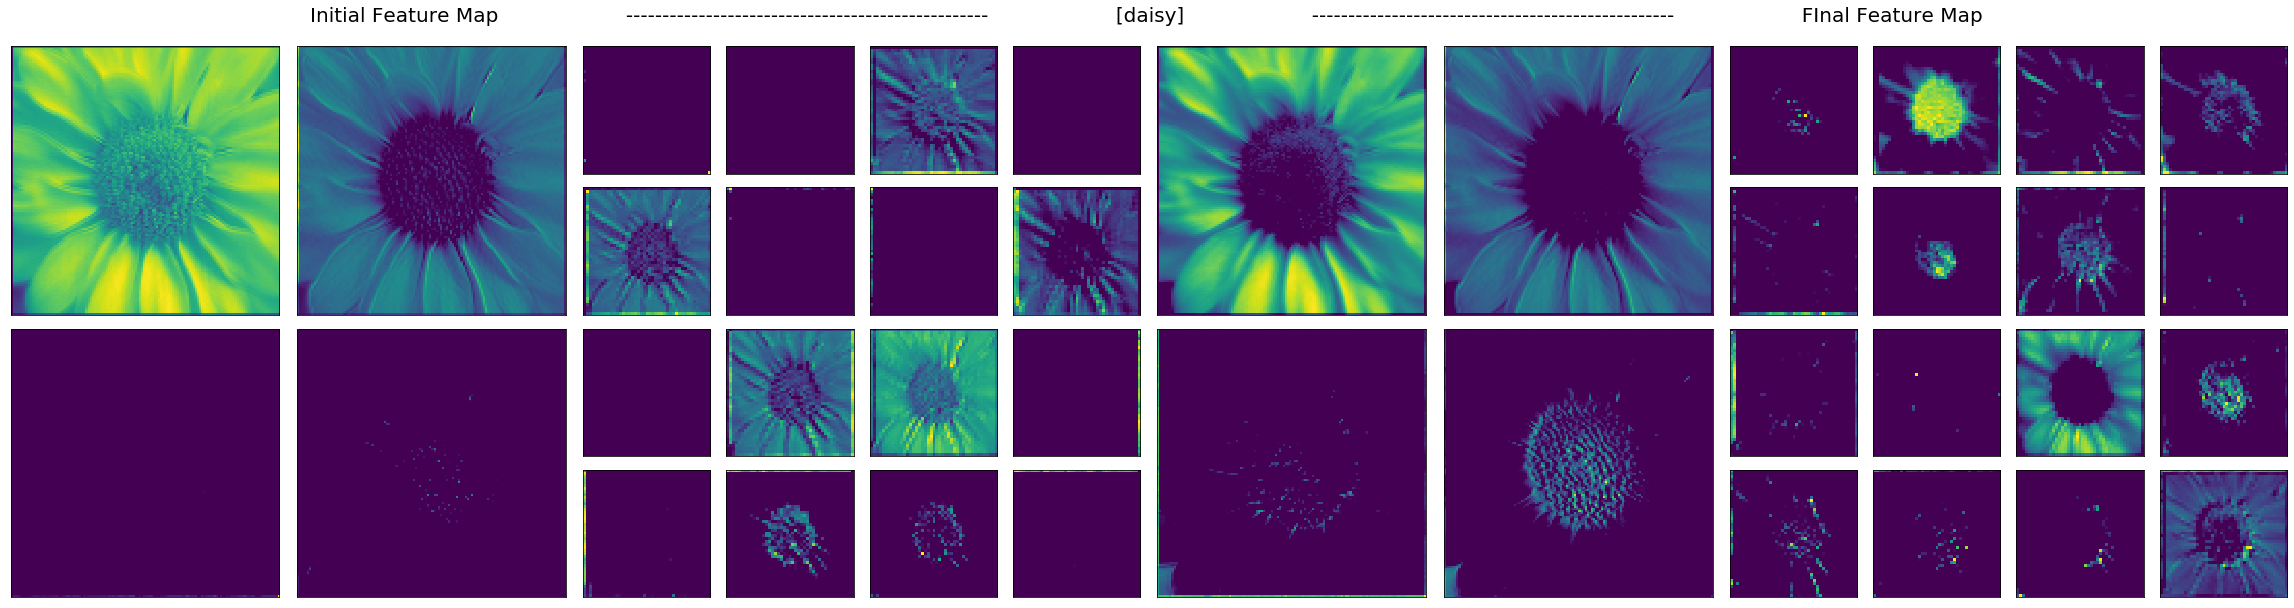

params_idx : 6 / model init : orthogonal
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the 

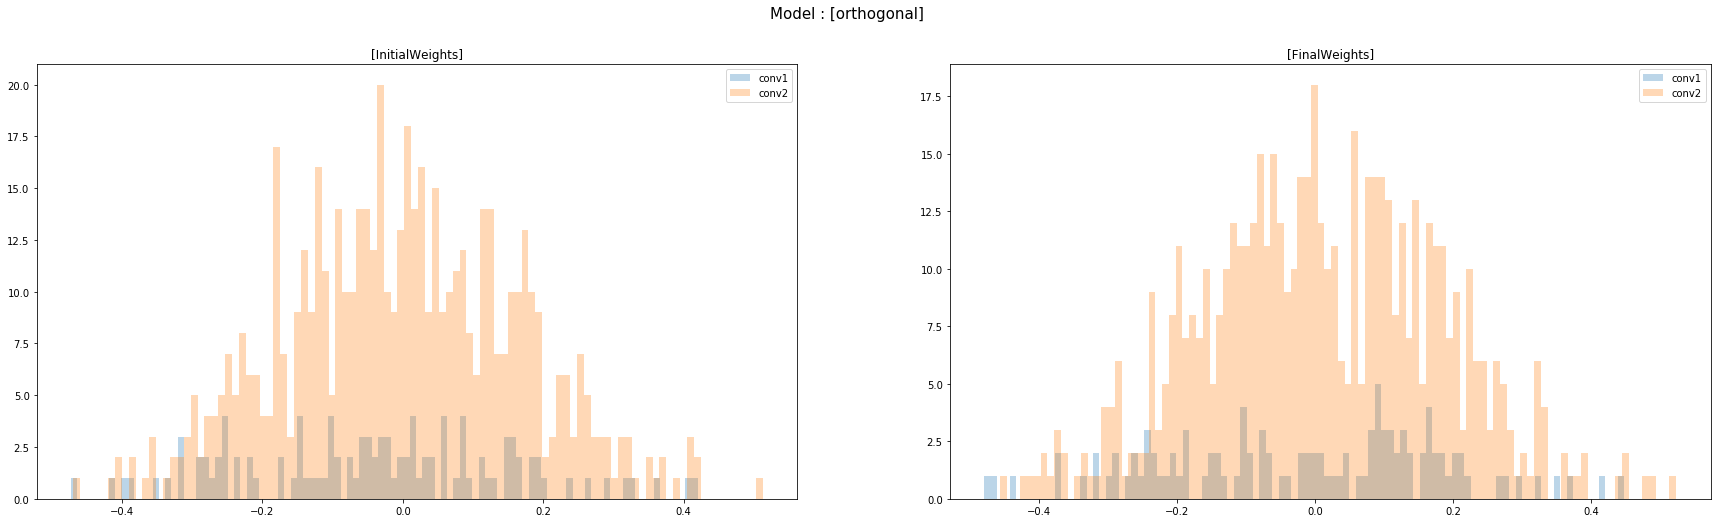

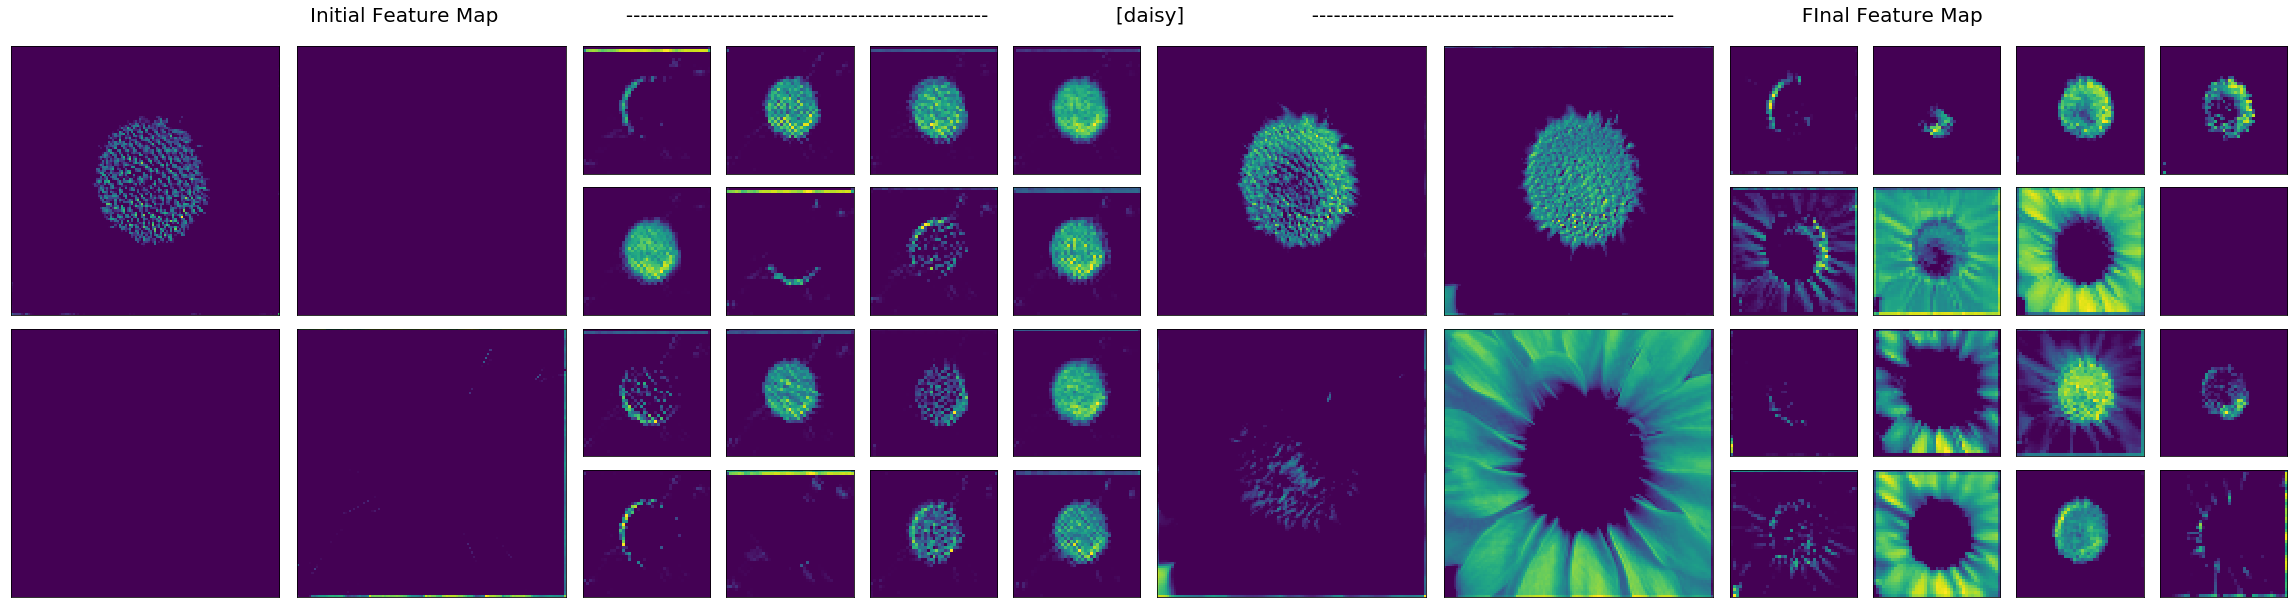

In [13]:
for idx,params in grid.iterrows():
    print(f'params_idx : {idx} / model init : {params["sInit"]}')
    
    # 초기 가중치, 최종 가중치 불러오기
    initial_cnn_model = CnnModel(params["sInit"]).cnn_model
    final_cnn_model = CnnModel(params["sInit"]).cnn_model
    
    initial_cnn_model.load_weights(f'C:/Users/begas/Model/Initial/{params["sInit"]}/model')
    final_cnn_model.load_weights(f'C:/Users/begas/Model/Final/{params["sInit"]}/model')
    
    # 초기 Weight / 최종 Weight 비교 Plot S ====================================================================
    # 초기 Weight
    fig, ax = plt.subplots(1,2,figsize = (30,8))
    for layer in initial_cnn_model.layers :
        if (len(layer.get_weights()) > 0 )and ('nor' not in layer.name )and ('dense' not in layer.name) :
            ax[0].hist(layer.get_weights()[0].flatten(), alpha = 0.3, label = layer.name, bins = 100)
    ax[0].legend()
    ax[0].set_title(f'[InitialWeights]')    
    
    # 최종 Weight
    for layer in final_cnn_model.layers :
        if (len(layer.get_weights()) > 0 )and ('nor' not in layer.name )and ('dense' not in layer.name):
            ax[1].hist(layer.get_weights()[0].flatten(), alpha = 0.3, label = layer.name, bins = 100)
    ax[1].legend()
    ax[1].set_title(f'[FinalWeights]')
    fig.suptitle(f'Model : [{params["sInit"]}]', fontsize = 15)
    
    # 초기 Weight / 최종 Weight 비교 Plot E ====================================================================
    
    # 초기 Feature Map / 최종 Feature Map 비교 S ===============================================================
    # Feature 추출 모델 생성
    output_layers_idx = [idx for idx,s in enumerate(initial_cnn_model.layers) if 'drop' in s.name]
    
    # 초기모델 Feature Map 추출
    initial_Feature_model_1 = tf.keras.Model(inputs = initial_cnn_model.layers[0].input, outputs = initial_cnn_model.layers[output_layers_idx[0]].output)
    initial_Feature_model_2 = tf.keras.Model(inputs = initial_cnn_model.layers[0].input, outputs = initial_cnn_model.layers[output_layers_idx[1]].output)
    initial_model_Feature_Map_1 = initial_Feature_model_1.predict(train_array_x, verbose=0)
    initial_model_Feature_Map_2 = initial_Feature_model_2.predict(train_array_x, verbose=0)
    
    # 최종모델 Feature Map 추출
    final_Feature_model_1 = tf.keras.Model(inputs = final_cnn_model.layers[0].input, outputs = final_cnn_model.layers[output_layers_idx[0]].output)
    final_Feature_model_2 = tf.keras.Model(inputs = final_cnn_model.layers[0].input, outputs = final_cnn_model.layers[output_layers_idx[1]].output)
    final_model_Feature_Map_1 = final_Feature_model_1.predict(train_array_x, verbose=0)
    final_model_Feature_Map_2 = final_Feature_model_2.predict(train_array_x, verbose=0)
       
    # for flower_name in flower_list:
    flower_name = flower_list[0]
    data_idx = 0
    initial_feature_1 = initial_model_Feature_Map_1[np.argwhere(train_y_dat == flower_name)][data_idx]
    initial_feature_2 = initial_model_Feature_Map_2[np.argwhere(train_y_dat == flower_name)][data_idx]

    final_feature_1 = final_model_Feature_Map_1[np.argwhere(train_y_dat == flower_name)][data_idx]
    final_feature_2 = final_model_Feature_Map_2[np.argwhere(train_y_dat == flower_name)][data_idx]

    # Conv Layer 1, Conv Layer 2 Feature Map 그래프 그리기

    fig=plt.figure(figsize = (32,8))
    gs=GridSpec(4,16)
    axes_list = []
    for y,x in list(itertools.product(range(16),range(4))):

        # Initial Feature Map Axis
        if (x == 0) and (y == 0) :
            axes_list.append(fig.add_subplot(gs[x:(x+2),y:(y+2)]))
        if (x == 0) and (y == 2) :
            axes_list.append(fig.add_subplot(gs[x:(x+2),y:(y+2)]))
        if (x == 2) and (y == 0) :
            axes_list.append(fig.add_subplot(gs[x:(x+2),y:(y+2)]))
        if (x == 2) and (y == 2) :
            axes_list.append(fig.add_subplot(gs[x:(x+2),y:(y+2)])) 

        if (y >= 4) and (y <=7):
            axes_list.append(fig.add_subplot(gs[x,y]))

         # Final Feature Map Axis    
        if (x == 0) and (y == 8) :
            axes_list.append(fig.add_subplot(gs[x:(x+2),y:(y+2)]))
        if (x == 0) and (y == 10) :
            axes_list.append(fig.add_subplot(gs[x:(x+2),y:(y+2)]))
        if (x == 2) and (y == 8) :
            axes_list.append(fig.add_subplot(gs[x:(x+2),y:(y+2)]))
        if (x == 2) and (y == 10) :
            axes_list.append(fig.add_subplot(gs[x:(x+2),y:(y+2)]))     

        if (y >= 12) :
            axes_list.append(fig.add_subplot(gs[x,y]))    

    ##  Initial Feature Map Axes
    # 첫번째 Conv Layer Feature Map
    for i in range(initial_feature_1.shape[-1]):
        axes_list[i].imshow(initial_feature_1[0,:,:,i])    

    # 두번째 Conv Feature Map
    for i in range(initial_feature_2.shape[-1]):
        axes_list[4+i].imshow(initial_feature_2[0,:,:,i]) 

    ##  Final Feature Map Axes    
    # 첫번째 Conv Layer Feature Map
    for i in range(final_feature_1.shape[-1]):
        axes_list[20 + i].imshow(final_feature_1[0,:,:,i])    

    # 두번째 Conv Feature Map
    for i in range(final_feature_2.shape[-1]):
        axes_list[24 + i].imshow(final_feature_2[0,:,:,i])

    for i in range(len(axes_list)):
        axes_list[i].set_xticks([])  
        axes_list[i].set_yticks([])  
    fig.tight_layout()    
    fig.suptitle(f'Initial Feature Map{" "*20}{"-"*50}{" "*20}[{flower_name}]{" "*20}{"-"*50}{" "*20}FInal Feature Map', fontsize = 20, y = 1.05)
    plt.show()
    
    # 초기 Feature Map / 최종 Feature Map 비교 E ===============================================================

### Evaluate

In [47]:
for idx, params in grid.iterrows() :
    train_metric = model_list[idx].cnn_model.evaluate(train_array_x,train_onehot_y, batch_size=len(train_onehot_y), verbose=0)
    valid_metric = model_list[idx].cnn_model.evaluate(valid_array_x,valid_onehot_y, batch_size=len(valid_onehot_y), verbose=0)
    test_metric = model_list[idx].cnn_model.evaluate(test_array_x,test_onehot_y, batch_size=len(test_onehot_y), verbose=0)
    
    print(f'{"-"*20}[Initializer - {params["sInit"]}]{"-"*20}')
    print(f'Train Loss : {round(train_metric[0],4)} / Train Acc : {round(train_metric[1] * 100,2)}%')
    print(f'Valid Loss : {round(valid_metric[0],4)} / Valid Acc : {round(valid_metric[1] * 100,2)}%')
    print(f'Test  Loss : {round(test_metric[0],4)} / Test  Acc : {round(test_metric[1] * 100,2)}%')

--------------------[Initializer - random_uniform]--------------------
Train Loss : 0.4269 / Train Acc : 91.35%
Valid Loss : 0.8448 / Valid Acc : 68.4%
Test  Loss : 0.9473 / Test  Acc : 63.6%
--------------------[Initializer - glorot_uniform]--------------------
Train Loss : 0.3672 / Train Acc : 92.95%
Valid Loss : 0.8797 / Valid Acc : 67.8%
Test  Loss : 0.9851 / Test  Acc : 64.0%
--------------------[Initializer - he_uniform]--------------------
Train Loss : 0.2306 / Train Acc : 97.2%
Valid Loss : 0.8993 / Valid Acc : 67.6%
Test  Loss : 1.1051 / Test  Acc : 60.6%
--------------------[Initializer - random_normal]--------------------
Train Loss : 0.6631 / Train Acc : 78.6%
Valid Loss : 0.9664 / Valid Acc : 62.2%
Test  Loss : 0.9899 / Test  Acc : 63.2%
--------------------[Initializer - glorot_normal]--------------------
Train Loss : 0.5167 / Train Acc : 86.05%
Valid Loss : 0.9103 / Valid Acc : 65.4%
Test  Loss : 0.9576 / Test  Acc : 65.0%
--------------------[Initializer - he_normal]---